0. Package Installation

In [12]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

print("numpy version : ",np.__version__)
print("opencv version : ",cv2.__version__)

numpy version :  1.20.3
opencv version :  4.5.5


1. 2D Fourier Transform of Images

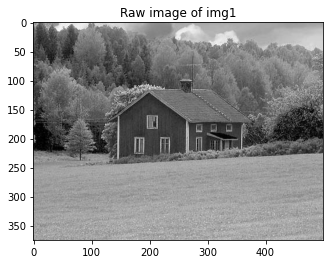

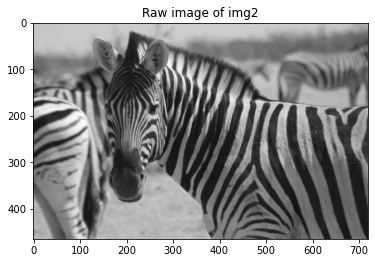

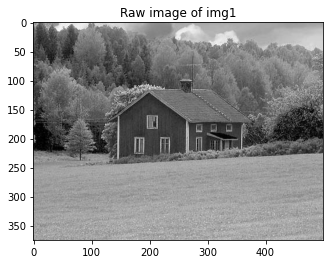

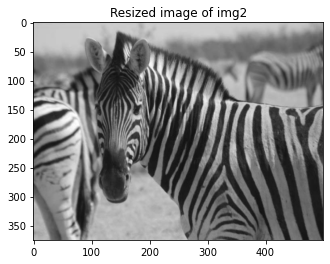

In [14]:
# image load
img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')

# plot raw image
plt.imshow(img1)
plt.title("Raw image of img1")
plt.show()
plt.imshow(img2)
plt.title("Raw image of img2")
plt.show()

# crop image2
h, w, c = img1.shape
img2 = cv2.resize(img2, (w,h), interpolation=cv2.INTER_AREA)
plt.imshow(img1)
plt.title("Raw image of img1")
plt.show()
plt.imshow(img2)
plt.title("Resized image of img2")
plt.show()

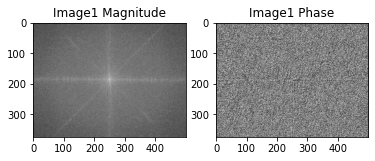

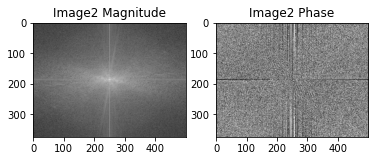

In [15]:
# DFT function
def DFT(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dft = cv2.dft(np.float32(img),flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude = 20*np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
    phase = cv2.phase(dft_shift[:, :, 0], dft_shift[:, :, 1])
    
    return magnitude, phase

img1_mag, img1_phase = DFT(img1)
img2_mag, img2_phase = DFT(img2)

plt.subplot(121),plt.imshow(img1_mag, cmap='gray')
plt.title('Image1 Magnitude')
plt.subplot(122),plt.imshow(img1_phase, cmap='gray')
plt.title('Image1 Phase')
plt.show()

plt.subplot(121),plt.imshow(img2_mag, cmap='gray')
plt.title('Image2 Magnitude')
plt.subplot(122),plt.imshow(img2_phase, cmap='gray')
plt.title('Image2 Phase')
plt.show()

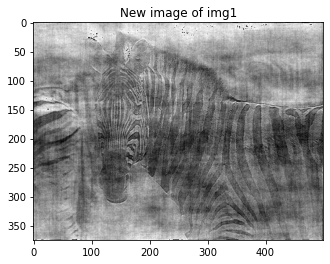

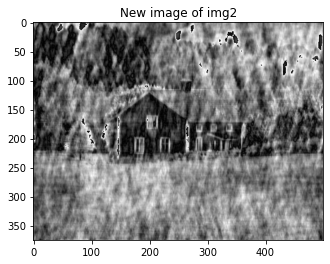

In [16]:
# mixed magnitude and phase
img1_fshift = np.exp(img1_mag/20) * np.exp(-1j * img2_phase)
img2_fshift = np.exp(img2_mag/20) * np.exp(-1j * img1_phase)

# IFFT function
def IFFT(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_back = np.array(img_back, dtype=np.uint8)
    img_back = cv2.cvtColor(img_back, cv2.COLOR_GRAY2BGR)
    
    return img_back

new_img1 = IFFT(img1_fshift)
new_img2 = IFFT(img2_fshift)

plt.imshow(new_img1)
plt.title("New image of img1")
plt.show()
plt.imshow(new_img2)
plt.title("New image of img2")
plt.show()

2. Perspective Image Transforms

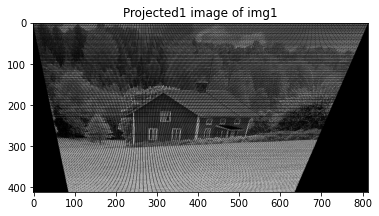

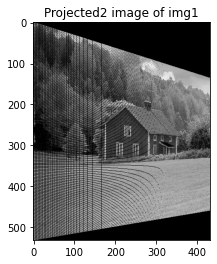

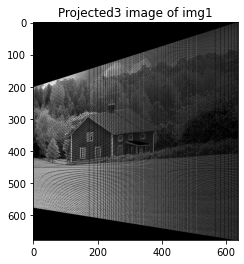

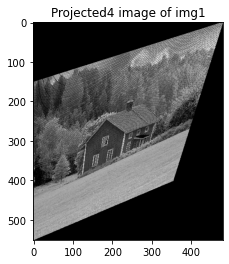

In [17]:
# 2D perspective projection matrix
M1 = [(1.6322, 0, 0), (0.2120, 1.6336, 0.0013), (-101.9757, -0.6322, 1.0000)]
M2 = [(1.4219, 0.3183, 0.0013), (0, 1.4206, 0), (-0.4206, -101.8704, 1.0000)]
M3 = [(0.7033, -0.2239, -0.0009), (0, 0.9991, 0), (0.2958, 0.2239, 1.0000)]
M4 = [(1.1044, -0.3493, 0.0003), (0.0011, 1.5066, 0.0011), (-0.1041, -0.1560, 1.0000)]

# make homogeneous coordinate
def homo_coordinate(img):
    img = img[:,:,0]
    shape = img.shape
    homo_vec = np.ones((*shape, 1))
    homo_vec[:,:,0]=img
    return homo_vec

homo_img1 = homo_coordinate(img1)

# transformation function : apply projection M on img
def transformation(img, M):
    img = img[:,:,0]
    w, h = img.shape
    w_size_max = 5000
    h_size_max = 5000
    u_min = h_size_max
    v_min = w_size_max
    u_max = 0
    v_max = 0
    result = np.zeros((w_size_max, h_size_max))
    for y in range(w):
        for x in range(h):
            before = np.reshape([x, y, 1], (1,3))
            after = before @ M
            p = after[0,0]
            q = after[0,1]
            r = after[0,2]
            u, v = int(p/r + h_size_max/2), int(q/r + w_size_max/2)
            if (u < u_min):
                u_min = u
            if (v < v_min):
                v_min = v
            if (u > u_max):
                u_max = u
            if (v > v_max):
                v_max = v
            result[v,u] = img[y, x]
    result = np.array(result, dtype=np.uint8)
    result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
    result = result[v_min:v_max, u_min:u_max]
    return result

result1 = transformation(homo_img1, M1)
result2 = transformation(homo_img1, M2)
result3 = transformation(homo_img1, M3)
result4 = transformation(homo_img1, M4)

# save the results
cv2.imwrite("projected1.jpg", result1)
cv2.imwrite("projected2.jpg", result2)
cv2.imwrite("projected3.jpg", result3)
cv2.imwrite("projected4.jpg", result4)

#plot the results
plt.imshow(result1)
plt.title("Projected1 image of img1")
plt.show()
plt.imshow(result2)
plt.title("Projected2 image of img1")
plt.show()
plt.imshow(result3)
plt.title("Projected3 image of img1")
plt.show()
plt.imshow(result4)
plt.title("Projected4 image of img1")
plt.show()

3. Camera Calibration

In [18]:
# input data array
u_ = np.array([880, 43, 270, 886, 745, 943, 476, 419, 317, 783, 235, 665, 655, 427, 412, 746, 434, 525, 716, 602])
v_ = np.array([214, 203, 197, 347, 302, 128, 590, 214, 335, 521, 427, 429, 362, 333, 415, 351, 415, 234, 308, 187])
X_ = np.array([312.747, 305.796, 307.694, 310.149, 311.937, 311.202, 307.106, 309.317, 307.435, 308.253, 306.650, 308.069, 309.671, 308.255, 307.546, 311.036, 307.518, 309.950, 312.160, 311.988])
Y_ = np.array([309.140, 311.649, 312.358, 307.186, 310.105, 307.572, 306.876, 312.490, 310.151, 306.300, 309.301, 306.831, 308.834, 309.955, 308.613, 309.206, 308.175, 311.262, 310.772, 312.709])
Z_ = np.array([30.086, 30.356, 30.418, 29.298, 29.216, 30.682, 28.660, 30.230, 29.318, 28.881, 28.905, 29.189, 29.029, 29.267, 28.963, 28.913, 29.069, 29.990, 29.080, 30.514])

# concatenate data
u_ = np.reshape(u_, (1,-1))
v_ = np.reshape(v_, (1,-1))
X_ = np.reshape(X_, (1,-1))
Y_ = np.reshape(Y_, (1,-1))
Z_ = np.reshape(Z_, (1,-1))
data = np.concatenate((u_, v_, X_, Y_, Z_), axis = 0)
data = np.transpose(data)

# make array A1 that A1*p = 0
A1 = []
for u, v, x, y, z in data:
    A1.append([x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u])
    A1.append([0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v])
A1 = np.array(A1)

# apply SVD : A = U * S * V^T
U, S, VT = np.linalg.svd(A1, full_matrices = True)
P1 = np.transpose(VT)[:,11]
P1 = np.reshape(P1, (3,4))
P1

array([[ 3.09963996e-03,  1.46204548e-04, -4.48497465e-04,
        -9.78930678e-01],
       [ 3.07018252e-04,  6.37193664e-04, -2.77356178e-03,
        -2.04144405e-01],
       [ 1.67933533e-06,  2.74767684e-06, -6.83964827e-07,
        -1.32882928e-03]])

In [19]:
# make array A2 that A2 * p = b m34=1
A2 = []
b = []
for u, v, x, y, z in data:
    A2.append([x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z])
    b.append([-u])
    A2.append([0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z])
    b.append([-v])
A2 = np.array(A2)

# apply pseudo inverse
invA = np.linalg.pinv(A2)
P2 = invA @ b
P2 = np.append(P2, [1])
P2 = np.reshape(P2, (3,4))
# normalize P
P2 = P2 / np.linalg.norm(P2)
P2

array([[ 3.09966577e-03,  1.46164454e-04, -4.48372807e-04,
        -9.78929847e-01],
       [ 3.07031352e-04,  6.37192048e-04, -2.77354632e-03,
        -2.04148391e-01],
       [ 1.67939661e-06,  2.74767732e-06, -6.83873524e-07,
         1.32885096e-03]])